# Analyse de la *Bibliothèque* du pseudo-Apollodore

## Objectif

Ce travail est lié à [ce projet](https://louislesueur.github.io/gods/). Le but est d'utiliser des outils de *Natural Language Processing* issus de la bibliothèque **CLTK** pour extraire les noms propres du texte et identifier les relations entre les personnages de façon automatisée.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering

from cltk.tag import ner
from cltk.stem.lemma import LemmaReplacer
from cltk.corpus.utils.formatter import tlg_plaintext_cleanup

Pour identifier les noms propres, on va utiliser un algorithme de CLTK qui permet d'identifier les entités nommées dans le texte, en utilisant une base de donnée pré-existante. 
On va définir une classe pour stocker efficacement ces entités.

In [2]:
class Entity:
    def __init__(self, word):
        self.word = word
        self.occurences = []

    def add_ocurence(self, occ):
        self.occurences.append(occ)

    def __str__(self):
        return self.word

    def __gt__(self, other):
        return self.word > other.word

    def __eq__(self, other):
        return self.word == other.word

    def get_table(self):
        return [self.word, *self.occurences]

## Quelques définitions

+ Un texte $T$ est une suite de mots.
+ Un mot est une suite finie de lettres
+ Une lettre est un élément d'un alphabet $\mathcal{A}$.
+ Une entité nommée est une expression linguistique le plus souvent associée à un nom propre.
+ On note $o_T(m)$ l'ensemble des positions du mot $m$ dans le texte $T$

## Distances entre entités

En première approximation, on va supposer que deux entités "proches" dans le texte ont de bonnes chances d'être en relation. On va donc définir quelques distances pour définir cette proximité:
+ En voyant les différentes positions d'une entité dans le texte comme un nuage de points en 1d, on peut définir une distance de type Chamfer: $d_{CH}(e_1,e_2) = \sum_{i \in o_T(e_1)} \min_{j \in o_T(e_2)} |i-j| + \sum_{i \in o_T(e_2)} \min_{j \in o_T(e_1)} |i-j|$
+ On considérera aussi la moyenne entre tous les écarts: $d_{M}(e_1,e_2) = \frac{1}{N} \sum_{i \in o_T(e_2), j \in o_T(e_1)} |i-j|$
+ Enfin, on peut aussi regarder le plus petit écart entre les différentes occurences: $d_{\min}(e_1,e_2)=\min_{i \in o_T(e_2), j \in o_T(e_1)} |i-j|$

In [3]:
def chamfer(ent1, ent2):
    S1 = np.array(ent1.occurences)
    S2 = np.array(ent2.occurences)
    return np.sum([np.min([np.linalg.norm(x-y) for y in S2]) for x in S1]) + np.sum([np.min([np.linalg.norm(x-y) for y in S1]) for x in S2])

def meandist(ent1, ent2):
    S1 = np.array(ent1.occurences)
    S2 = np.array(ent2.occurences)
    return np.mean([[np.linalg.norm(x-y) for y in S2] for x in S1])

def mindist(ent1, ent2):
    S1 = np.array(ent1.occurences)
    S2 = np.array(ent2.occurences)
    return np.min([[np.linalg.norm(x-y) for y in S2] for x in S1])

Avec ces différentes distances, on va construire des matrices de distances. Celles-ci étant symétriques, on peut ne calculer que la moitié des coefficients et symétriser après.

In [4]:
def symmetrize(a):
    return a + a.T - np.diag(a.diagonal())

## Extraction des données de la *Bibliothèque* (n'exécuter les cellules que si nécessaire !)

Le texte a été récupéré sur [Perseus](perseus.tufts.edu).

In [5]:
data = ""
with open('Apollodore_text', 'r') as file:
    for l in file.readlines():
        data += l.strip()

file.close()

On élimine la ponctuation et les fioritures issues de la mise en forme de Perseus, et on applique l'algorithme de NER (*Name Entity Recognition*) de cltk.

In [6]:
data = tlg_plaintext_cleanup(data, rm_punctuation=True, rm_periods=False)
out = ner.tag_ner('greek',data, output_type=list)

Le Grec ancient est une langue à cas. Donc une même entité peut être représentée par deux mots différents. On doit donc lemmatiser pour revenir au nominatif de chaque nom et s'assurer que les entités trouvées sont bien distinctes.

In [7]:
lemmatizer = LemmaReplacer('greek')
entities = []

for i in range(len(out)):
    if len(out[i]) == 2:
        ent = Entity(lemmatizer.lemmatize(out[i][0])[0])
        add = True
        for j in range(len(entities)):
            if ent == entities[j]:
                entities[j].add_ocurence(i)
                add = False
        if add:
            ent.add_ocurence(i)
            entities.append(ent)

Comme l'exécution peut prendre du temps, on sauvegarde les entités et leurs occurences dans un fichier texte.

In [8]:
TABLE_ENTITIES = [ent.get_table() for ent in entities]
np.savetxt('entities', TABLE_ENTITIES, fmt='%s')

Enfin, on génère les matrices de distance et on les enregistre aussi dans des fichiers textes.

In [9]:
CHAMFER = np.zeros((len(entities), len(entities)))
MEAN = np.zeros((len(entities), len(entities)))
MIN = np.zeros((len(entities), len(entities)))

for i in range(len(entities)):
    for j in range(len(entities)):
        if i >= j:
            CHAMFER[i,j] = chamfer(entities[i], entities[j])
            MEAN[i,j] = meandist(entities[i], entities[j])
            MIN[i,j] = mindist(entities[i], entities[j])

CHAMFER = symmetrize(CHAMFER)
MEAN = symmetrize(MEAN)
MIN = symmetrize(MIN)

np.savetxt('distance_matrices/chamfer',CHAMFER, fmt='%i')
np.savetxt('distance_matrices/mean',MEAN, fmt='%1.3f')
np.savetxt('distance_matrices/min',MIN, fmt='%1.3f')

## Analyse des données

### Généralités

Récupération des données:

In [13]:
ENTITIES = []
with open('entities', 'r') as file:
    for l in file.readlines():
        clear = l[1:-2].replace("'", "").split(',')
        ENTITIES.append([clear[0], [int(i) for i in clear[1:]]])

CHAMFER = np.loadtxt('distance_matrices/chamfer', dtype="int")
MEAN = np.loadtxt('distance_matrices/mean', dtype="float")
MIN = np.loadtxt('distance_matrices/min', dtype="float")

On peut commencer par regarder la distribution des entités dans le texte:

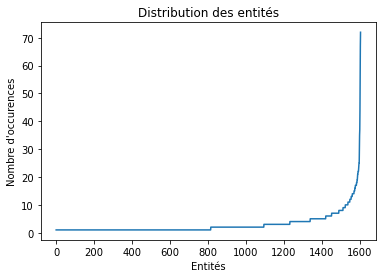

In [17]:
plt.figure()
plt.title("Distribution des entités")
plt.xlabel("Entités")
plt.ylabel("Nombre d'occurences")
plt.plot(np.sort([len(ent[1]) for ent in ENTITIES]))
plt.show()

La distribution a donc forme exponentielle, et on a:

In [21]:
print(f"10 entités les moins citées: {[ENTITIES[idx][0] for idx in np.argsort([len(ent[1]) for ent in ENTITIES])[:10]]}")
print(f"10 entités les plus citées: {[ENTITIES[idx][0] for idx in np.argsort([len(ent[1]) for ent in ENTITIES])[-10:]]}")

10 entités les moins citées: ['ἄντεια', 'τμῶλος', 'λυδός', 'ἰάρδανος', 'τιρύνθιος', 'κευθώνυμος', 'λακωνικός', 'ἐφέζομαι', 'ταίναρος', 'πυρήνη']
10 entités les plus citées: ['ἀπόλλων', 'ἑρμῆς', 'ἀπόλάω1', 'μίνως', 'ἄργος', 'θῆβαι', 'Διὸς', 'Ζεὺς', 'ἀθήνη', 'ποσειδῶν']


Sans surprise, les entités les plus cités sont des noms propres de divinités, les moins citées sont celles de personnages très anecdotiques, et de mots qui ont mal été identifiés par l'algorithme. Néanmoins, on remarque que Διὸς est présent dans les plus citées. Or, il provient clairement de l'irrégularité de la déclinaison de Zeus:

| Cas       | Déclinaison       |
|-----------|-------------------|
|N |	ὁ Ζεύς          |
|V 	|Ζεῦ                |
|A |	τὸν Δῐ́ᾰ / Ζῆνᾰ  |
|G 	|τοῦ Δῐός / Ζηνός   |
|D 	|τῷ Δῐῐ́ / Ζηνῐ́      |


C'est un problème qu'il faudra régler à l'avenir

### Distances

Pour une entité quelconque, on peut afficher la distance de cette entité par rapport à toutes les autres, en normalisant pour pouvoir comparer:

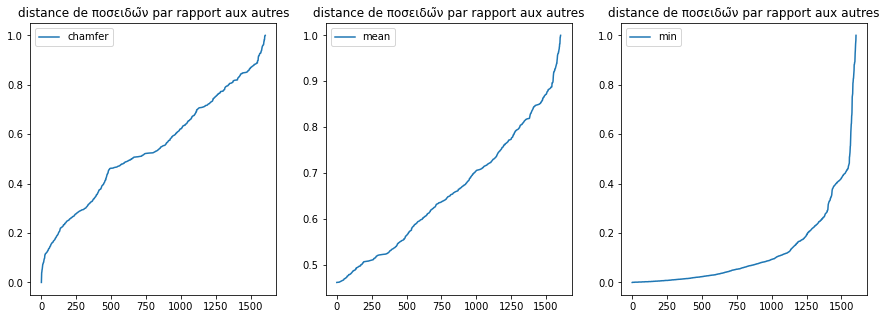

In [30]:
fig = plt.figure(figsize=(15,5))

fig.add_subplot(1, 3, 1)
plt.title(f"distance de {ENTITIES[33][0]} par rapport aux autres")
plt.plot(np.sort(CHAMFER[33])/np.max(CHAMFER[33]), label='chamfer')
plt.legend()

fig.add_subplot(1, 3, 2)
plt.title(f"distance de {ENTITIES[33][0]} par rapport aux autres")
plt.plot(np.sort(MEAN[33])/np.max(MEAN[33]), label='mean')
plt.legend()

fig.add_subplot(1, 3, 3)
plt.title(f"distance de {ENTITIES[33][0]} par rapport aux autres")
plt.plot(np.sort(MIN[33])/np.max(MIN[33]), label='min')
plt.legend()

plt.show()

On voit que $d_{\min}$ a de plus fortes variations, et ça sera d'ailleurs celle-ci qui donnera les meilleurs résultats pour le clustering.

### Clustering pour la min distance

On va maintenant effectuer le clustering. Les résultats avec la distance de Chamfer et la mean distance étant mauvais, on se focalisera sur ceux donnés par la min distance. Après plusieurs tests, un regroupement hiérarchique donne des résultats satisfaisants.

In [38]:
agg = AgglomerativeClustering(affinity="precomputed", linkage='complete', n_clusters=100)

Y = agg.fit_predict(MIN)
for i in range(np.max(Y)+1):
    print(f"cluster {i} ({len(np.where(Y==i)[0])} élements):")
    print([ENTITIES[idx][0] for idx in np.where(Y==i)[0]][:10])

cluster 0 (16 élements):
['ἄδραστος', 'μελάμπους', 'πηρόω', 'ταλαός', 'παρθενοπαῖος', 'πρῶ/ναξ', 'Μηκιστεὺς', 'ἀριστόμαχος', 'ἀμφιθέη', 'Αἰγιαλεὺς']
cluster 1 (19 élements):
['ὀρέστης', 'ὄξυλος', 'ἀνδραίμων', 'λοκρίς', 'αἰγίμιος', 'τισαμενός', 'πελοποννήσιος', 'πελοποννήσιοι', 'κλεόδαιος', 'τήμενος']
cluster 2 (34 élements):
['ἄγριος', 'φθῖος', 'μεσσήνη', 'εὐρύθεμις', 'κλεοβοία', 'ἀλθαία', 'λήδη', 'ὑπερμνήστρη', 'ἴφικλος', 'πλήξιππος']
cluster 3 (24 élements):
['τρίτων', 'φρύγιος', 'γανυμήδης', 'καλλιρρόη', 'βατεία', 'δάρδανος', 'σαμοθράικη', 'σκάμανδρος', 'ἰδαῖος', 'δαρδάνιος']
cluster 4 (15 élements):
['κόρινθος', 'τάλος', 'σύλευς', 'ἀθηναῖος', 'μινώταυρος', 'ἀλκίππη', 'μητίων', 'αἰγληίς', 'ὀρθαίη', 'γέραιστος']
cluster 5 (15 élements):
['Ἰνδοὺς', 'σάτυρος', 'θράκη', 'ἀκταίων', 'βαλίος', 'Αἴγυπτόν', 'Πρωτεὺς', 'κύβελα', 'Ῥέας', 'βάκχη']
cluster 6 (15 élements):
['λῆμνος', 'θράικη', 'εὔνηος', 'νεβροφόνος', 'δολίων', 'κύζικος', 'Πελασγικὸν', 'ὑλάω', 'θειοδάμας', 'ἀφεταί']
cluste

Si on demande deux clusters, on voit se dégager des ensembles cohérents, par exemple:
+ Le cluster 13 contient les entités liées à la naissance d'Apollon.
+ Le cluster 35 contient des héros de la guerre de Troie.


# Conclusion et perspectives

On a donc un algorithme qui repère et clusterise les entités de façon cohérente. Néanmoins plusieurs évolutions et problèmes sont à traiter:
+ Il faut affiner la détection d'entités, qui n'élimine pas totalement les doublons.
+ Il faut distinguer les lieux des personnages dans les entités.
+ Il faut tester l'algorithme sur d'autres textes pour voir s'il fonctionne aussi sur des textes plus généraux (le clustering est probablement grandement facilité par le fait que la *Bibliothèque* soit elle-même très structurée.
+ Il faut établir les relations entre les personnages et entre les clusters.